In [1]:
pwd()

"/home/xlx0727/Scripts/Statistic/qgplsim"

# DGP

In [2]:
using DelimitedFiles, Distributions

In [9]:
student_t = StudentizedRange(2, 4)

StudentizedRange{Float64}(ν=2.0, k=4.0)

In [10]:
ϵt = rand(student_t, 10000)

10000-element Vector{Float64}:
  3.597979789938165
  3.54969319195895
  1.5564408719413056
  2.9871760537417775
  1.5702612075927673
  1.4713240568694907
  1.531758424185755
  0.5374031508111166
  4.856515132555273
  1.1463886382318578
  3.820407011188215
  4.191334478526554
  0.8295125083789314
  ⋮
  2.7216024303752797
  1.7094553365533702
  4.0258985664497144
  1.6588917004283081
  0.47473328443318397
  2.6007504715895897
  2.036553256417447
  1.461644737711964
  5.64813107594452
  0.5850625578635363
  1.5203503932945144
 10.190779151110418

In [11]:
filename = "studentized.txt"
open(filename, "a") do io
    writedlm(io, ϵt)
end

In [14]:
et = readdlm(filename, Float64)
size(et)

(12000, 1)

In [15]:
e = rand(et, n)

6000-element Vector{Float64}:
  4.575047142797644
  3.6848878453291003
  1.4426902734647504
  4.209871105904695
  0.5774682553585652
  1.47508605912979
  1.4492245006190492
  4.695030199548825
  3.762500417028904
  4.012531803565649
  0.9054745045662814
  2.154154289028013
  4.284527601874077
  ⋮
 10.812945017834114
  1.6525078329575664
  3.2635142676477127
  1.2218268950158504
  0.4048278192420169
  5.177750852382616
  5.9665998714651405
  1.2367083901430007
  3.3237275896104896
  2.108477846580277
  2.5742790140207097
  1.7305087729367528

# QGPLSIM fitting

In [137]:
# run this ceil if source codes was edited
include("DGP.ji")
# include("qgplsim.ji")
include("qgplsim.ji")
using Statistics, LinearAlgebra, Clustering

In [95]:
α = [-1.0, 1.0, -0.5, 4.0, 2.0] # single index for x, α[1] = c0
θ = [ 0.0, 1.0, 2.0, 1.0./2.0, -1.0]  # linear for x, <α, θ> = 0 for identification, θ[1] = c1 := 0
γ = [0.5, 1.0, -0.5]  * 1.0 # single index for z
# β = [-1.0, 0.5] # linear for z
β = [0.5, -0.5, -0.5] * 1.0

# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)
n_ = 250
n0 = 500
n1 = 750
n2 = 1000
n3 = 1500
n4 = 2000
n5 = 3000
n6 = 4000
n7 = 6000
n8 = 8000
n9 = 12000
n = n2

fx = 2 # y = f(x), fx for different f(x)     
                # fx = 1, y = X*θ + Z*β + (X*α + Z*γ .- 1).^2 + 0.2ϵ
                # fx = 2, y = X*θ + Z*β + log.(1 .+ exp.(X*α + Z*γ .- 1)) + 0.2ϵ

ifz = true # if false, Z = 0, i.e. no category varible
dist = 0 # 0 for gauss, 1 for t
X, Z, y = dgp(n, γ, θ, α, β, fx, dist,  ifz)
# p = length(α)
# q = length(γ)
τ = 0.5
widthExp = -0.17
intercept = 0
# Estimation 

model1 = qgplsim.model(X, Z, y, τ, widthExp, intercept)
alpha_type = 1

# different weight of sum on alpha 
# 0 for true alpha, using α in DGP
# 1 for estimated  ̂α

@time alpha, gamma, theta, beta = qgplsim.estimator(model1, alpha_type)

println("Estimation of index coefs: ")
println("̂α => ", alpha)
println("̂γ => ", gamma)

println("Estimation of linear coefs: ")
println("̂θ => ", theta)
println("̂β => ", beta)

# theta * alpha

  2.531334 seconds (21.13 M allocations: 9.408 GiB, 25.30% gc time)
Estimation of index coefs: 
̂α => [0.22216759222065208, -0.0901724044187143, 0.8716476813227299, 0.4274819506048586]
̂γ => [-0.041792023447337644, 0.25660424465040155, -0.16930490126682018]
Estimation of linear coefs: 
̂θ => [0.9920768048878489; 1.9509917939034496; 0.4403959462117683; -1.0020348198462283]
̂β => [0.586673219833787, -0.18669379303251132, 0.07178041655263391]


In [107]:
model1.alpha

4-element Vector{Float64}:
  0.22216759222065208
 -0.0901724044187143
  0.8716476813227299
  0.4274819506048586

In [97]:
alpha ./ alpha[1] |> transpose

1×4 transpose(::Vector{Float64}) with eltype Float64:
 1.0  -0.405876  3.92338  1.92414

In [98]:
norm(α)

4.716990566028302

In [101]:
gamma * norm(α) * 0.8

3-element Vector{Float64}:
 -0.1577060642690602
  0.96831984097501
 -0.6388876976463551

# Quantreg and GLM fitting

In [2]:
using DataFrames, QuantReg, GLM

In [3]:
dft = DataFrame([X y])

formula = Term(:x5) ~ sum([Term(x) for x in [:x1, :x2, :x3, :x4]])

qmodel = QuantRegModel(formula, dft)
QuantReg.fit(qmodel)


x5 ~ 1 + x1 + x2 + x3 + x4, τ=0.5


Degrees of freedom: 1000 total; 995 residual

────────────────────────
             Coefficient
────────────────────────
(Intercept)     1.0866
x1              2.27964
x2              1.53174
x3              1.557
x4              0.411786
────────────────────────

In [4]:
lm(formula, dft)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

x5 ~ 1 + x1 + x2 + x3 + x4

Coefficients:
─────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  1.21613    0.0211369   57.54    <1e-99   1.17465    1.25761
x1           2.28726    0.0210964  108.42    <1e-99   2.24586    2.32866
x2           1.50463    0.0220314   68.29    <1e-99   1.4614     1.54786
x3           1.52847    0.0214012   71.42    <1e-99   1.48648    1.57047
x4           0.438439   0.0205898   21.29    <1e-82   0.398035   0.478843
─────────────────────────────────────────────────────────────────────────

# QGPLSIM prediction

In [ ]:
using Plots

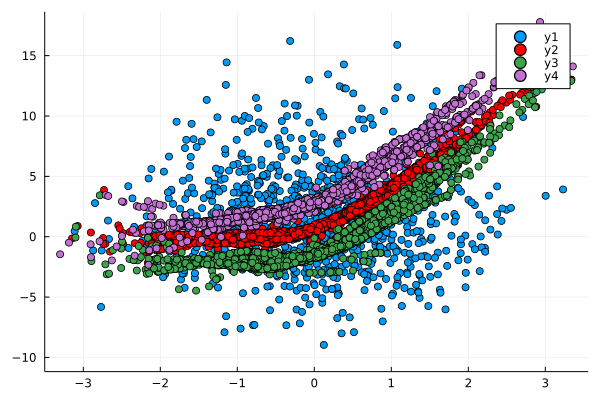

In [130]:
X, Z, y = dgp(2000, γ, θ, α, β, fx, dist, ifz, 1.6)

model1 = qgplsim.model(X, Z, y, 0.5)
qgplsim.estimator(model1)
v1 = X * model1.alpha
yp1 = qgplsim.predict(model1, X, Z, 0)

model2 = qgplsim.model(X, Z, y, 0.1)
qgplsim.estimator(model2)
v2 = X * model2.alpha
yp2 = qgplsim.predict(model2, X, Z, 0)

model3 = qgplsim.model(X, Z, y, 0.9)
qgplsim.estimator(model3)
v3 = X * model3.alpha
yp3 = qgplsim.predict(model3, X, Z, 0)

scatter(v, y)
scatter!(v1, yp1, color = "red")
scatter!(v2, yp2)
scatter!(v3, yp3)

## Paths of $g(x \alpha + z \gamma)$ and $\nabla g$

$\alpha = \hat{\alpha}$,
$z \in S_z$

width = 0.6716841133374799
dy = 0.2815371851442344
dx = 0.9620415295823663


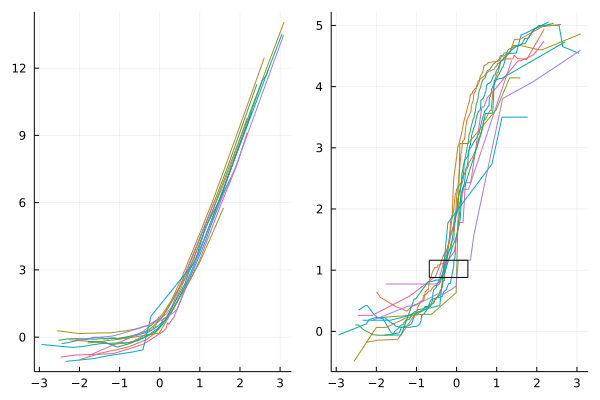

In [105]:
g = zeros(n)
dg = zeros(n)
yz = y - X * theta


X = [ones(n, intercept) X]
v = X * alpha
categ, index = model1.categ, model1.index
z = collect(index)
ncateg = index.count
width = zeros(ncateg)
v0 = -1e6
v1 = 1e6

for k in 1:ncateg
    vk = v[z[k][2]]
    h = (length(vk))^(-0.17) * var(vk)
    width[k] = h

    dgk(u) = qgplsim.Gz(u, vk, yz[z[k][2]], 1, τ)
    gk(u) = qgplsim.Gz(u, vk, yz[z[k][2]], 0, τ)

    dg[z[k][2]] = dgk(vk)
    g[z[k][2]] = gk(vk)

    vkmin = minimum(vk) + h # + h
    vkmax = maximum(vk) - h# - h

    if  vkmin > v0
        v0 = vkmin
    end
    if  vkmax < v1
        v1 = vkmax
    end  
end

# g, dg = qgplsim.G(v, Z, yz, τ, -0.4) # g: g(v), dg: g'(v)

println("width = ", mean(width))
# v0, v1 = v0 + h, v1 - h
# v0, v1

v_ = v[v .> v1]
_v = v[v .< v0]

v_ = minimum(v_)
_v = maximum(_v)
# _v, v_

C0 = zeros(ncateg)
C1 = zeros(ncateg)
dgf(vv, k) = qgplsim.Gz(vv, v[z[k][2]], yz[z[k][2]], 1, τ)


p1 = plot()
p2 = plot()
for m in 1:ncateg
    C0[m] = dgf(_v, m)[1]
    C1[m] = dgf(v_, m)[1]

    vm = v[index[categ[m]]]
    dgm = dg[index[categ[m]]]
    gm = g[index[categ[m]]]
    indm = sortperm(vm)
    sorted_dgm = dgm[indm]
    sorted_gm = gm[indm]
    sorted_vm = vm[indm]
    plot!(p1, sorted_vm, sorted_gm, label = false ) # L"g_{%$m} (v)")
    plot!(p2, sorted_vm, sorted_dgm, label = false ) # L"\nabla g_{%$m} (v)")

end

c0 = maximum(C0)
c1 = minimum(C1)
println("dy = ", c1 - c0)
println("dx = ", v1 - v0)

plot!(p2, [v0, v0], [c0, c1], color = "black", label = false)
plot!(p2, [v1, v1], [c0, c1], color = "black", label = false)
plot!(p2, [v0, v1], [c0, c0], color = "black", label = false)
plot!(p2, [v0, v1], [c1, c1], color = "black", label = false)


plot(p1, p2, layout = (1,2))

In [214]:
Threads.nthreads()

2

In [19]:
include("MonteCarloSIM.ji")

α = [-1.0, 1.0, -3.0] # single index for x
θ = [0.0, 3.0, 1.0]  # linear for x, <α, θ> = 0 for identification
γ = [0.5, 1.0]  # single index for z
# β = [-1.0, 0.5] # linear for z
β = [0.5, -0.5] 
widthExp = -0.17
τ = 0.5
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)
n = 500
fx = 2
dist = 0 # 1 for t
intercept = 0
rep = 100 # MC rept. times

100

# Monte Carlo

# Monte Carlo Simulation

In [20]:
@time Alpha, Gamma, Theta, Beta = MonteCarlo(n, γ, θ, α, β, 0.5, fx, dist, widthExp, intercept, rep)

mb1 = mean(Beta, dims = 1)

mt1 = mean(Theta, dims = 1)

ma1 = mean(Alpha, dims = 1)

mg1 = mean(Gamma, dims = 1) 

 50.054629 seconds (478.15 M allocations: 195.403 GiB, 25.74% gc time, 2.51% compilation time)


1×2 Matrix{Float64}:
 0.387341  0.776403

In [248]:
var1 = var(Gamma, dims = 1)

1×2 Matrix{Float64}:
 0.0203873  0.0103886

In [10]:
mt1

1×2 Matrix{Float64}:
 1.02292  1.98037

In [8]:
ma1

1×2 Matrix{Float64}:
 0.886613  -0.456838

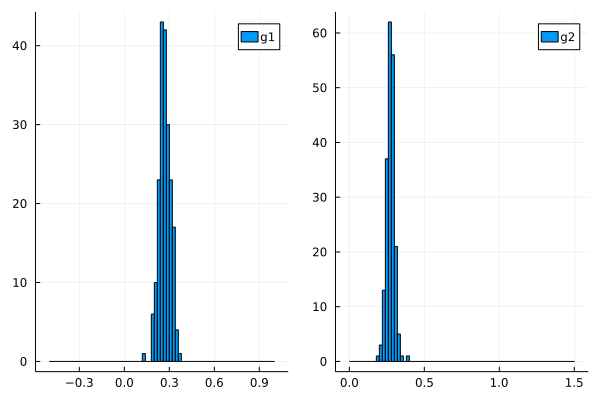

In [159]:
p1 = histogram(Gamma[:,1], bins = -0.5:0.02:1, label = "g1")
p2 = histogram(Gamma[:,2], bins = 0:0.02:1.5, label = "g2")
plot(p1, p2, layout = (1, 2))

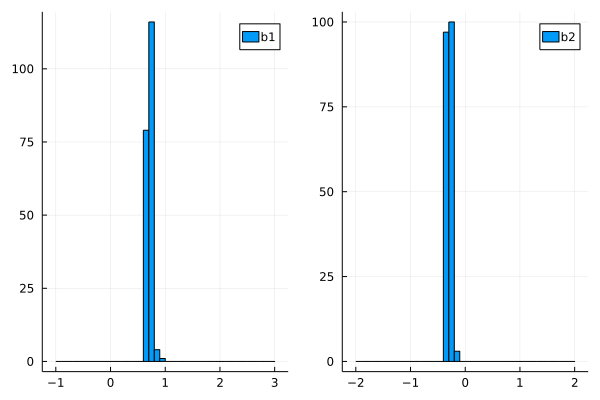

In [147]:

p1 = histogram(Beta[:,1], bins = -1:0.1:3, label = "b1")
p2 = histogram(Beta[:,2], bins = -2:0.1:2, label = "b2")
plot(p1, p2, layout = (1, 2))

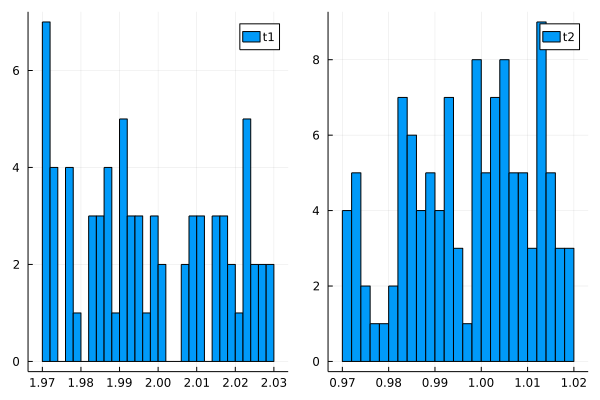

In [14]:
p1 = histogram(Theta[:,1], bins = 1.97:0.002:2.03, label = "t1")
p2 = histogram(Theta[:,2], bins = 0.97:0.002:1.02, label = "t2")
plot(p1, p2, layout = (1, 2))

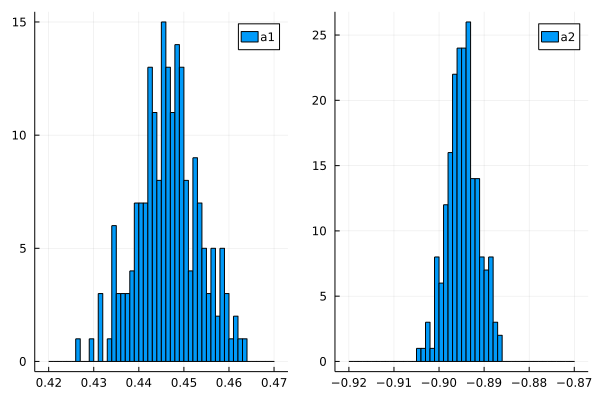

In [16]:
p1 = histogram(Alpha[:,1], bins = 0.42:0.001:0.47, label = "a1")
p2 = histogram(Alpha[:,2], bins = -0.92:0.001:-0.87, label = "a2")
plot(p1, p2, layout = (1, 2))

# Postprocess

In [53]:
α = [-1.0, 1.0, -0.5, 4.0, 2.0] # single index for x
# lenα = norm(α)
θ = [0.0, 1.0, 2.0, 0.5, -1.0]  # linear for x, <α, θ> = 0 for identification
# γ = [1.0, 0.5] # single index for z
β2 = [0.5, -0.5] # linear for z
β3 = [0.5, -0.5, -0.5] # linear for z
Γ2 = [[0.5, 0.001], [0.5, 1.0], [0.001, 0.5], [1.0, 0.5], [0.5, 0.5]] 
Γ3 = [[0.001, 0.001, 0.001], [0.001, 0.5, 0.5], [0.001, 0.5, 1.0], [0.5, 0.5, 0.5], [0.5, 1.0, 2.0]] 
include("postprocess.ji")

mean_var (generic function with 4 methods)

In [47]:
function mse(mat, vec, n)
    vec = transpose(vec)
    mat_vec = mat - repeat(vec, n, 1)
    mse = sum(mat_vec.^2, dims = 2) |> sum
    mse = mse / n
end

mse (generic function with 2 methods)

In [87]:
agbt3 = read_agbt(500,2,0,1, "./simulations/dz3/")

lena = norm(α)
γ = Γ3[1] 
Gamma = agbt3[:, 5:7] * lena * 0.8

mse(Gamma, γ, 100)

1.0824867314461994

In [75]:
gk = 2
agbt2 = read_agbt(1000,2,1,gk)

lena = norm(α)

γ = Γ2[gk] 

Gamma = agbt2[:, 5:6] * lena * 0.80
mse(Gamma, γ, 100)

0.08936626528824643

In [76]:
mean(Gamma, dims = 1)

1×2 Matrix{Float64}:
 0.45832  0.990662

In [41]:
Alpha = agbt2[:, 1:4] * lena
mean(Alpha, dims = 1)

1×4 Matrix{Float64}:
 0.993321  -0.450712  3.98013  2.02877

In [48]:
mse(Alpha, α[2:end], 100)

1.1065700508932266

In [46]:
α

5-element Vector{Float64}:
 -1.0
  1.0
 -0.5
  4.0
  2.0